# Twitter Sentimental Analysis

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install twitter

     |████████████████████████████████| 61kB 2.0MB/s 


In [6]:
! pip install nltk

In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import numpy as np
import pandas as pd

from twitter import Twitter
from twitter import OAuth

from nltk.corpus import stopwords

from pandas import json_normalize
import seaborn as sns

import re
from textblob import TextBlob

import matplotlib.pyplot as plt

from wordcloud import WordCloud

sns.set_style('white')

In [0]:
log = pd.read_excel('/content/drive/My Drive/Colab Notebooks/login.xlsx')

In [0]:
apikey=log['Keys'][0]
apisecretkey=log['Keys'][1]
accesstoken=log['Keys'][2]
accesstokensecret=log['Keys'][3] 

In [0]:
oauth = OAuth(accesstoken,accesstokensecret,apikey,apisecretkey)
api = Twitter(auth=oauth)

In [0]:
# only shows the top 200 tweets
twitter_json = api.statuses.user_timeline(screen_name='realDonaldTrump', twitter_mode='extended', count=200)

In [12]:
twitter_df = json_normalize(twitter_json)
twitter_df.shape

(200, 290)

In [13]:
twitter_df.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       ...
       'retweeted_status.quoted_status.retweet_count',
       'retweeted_status.quoted_status.favorite_count',
       'retweeted_status.quoted_status.favorited',
       'retweeted_status.quoted_status.retweeted',
       'retweeted_status.quoted_status.possibly_sensitive',
       'retweeted_status.quoted_status.lang',
       'retweeted_status.quoted_status.entities.media',
       'retweeted_status.quoted_status.extended_entities.media',
       'retweeted_status.quoted_status.quoted_status_id',
       'retweeted_status.quoted_status.quoted_status_id_str'],
      dtype='object', length=290)

In [0]:
# higher the id, newer the tweet 
min_id = twitter_df['id'].min() 

In [0]:
# To get more previous 200 tweets change the max_id parameter to the last id - 1
min_id = min_id - 1

twitter_json2 = api.statuses.user_timeline(screen_name='realDonaldTrump',
                                           twitter_mode='extended',
                                           count=200,
                                           max_id=min_id)

twitter_df2 = json_normalize(twitter_json2)

In [0]:
# We loop the 200 rows each time from the users timeline and created a new dataframe 

df = pd.DataFrame()
last_id = 0
for i in range(30):
    if i==0:
        twitter_json = api.statuses.user_timeline(screen_name='realDonaldTrump',
                                                  twitter_mode='extended',
                                                  count=200)
    else:
        twitter_json = api.statuses.user_timeline(screen_name='realDonaldTrump',
                                                  twitter_mode='extended',
                                                  count=200,
                                                  max_id=last_id)
    if len(twitter_json)>0:
        twitter_df = json_normalize(twitter_json)
        last_id = twitter_df['id'].min()
        last_id = last_id-1
        df = pd.concat([df, twitter_df], ignore_index=True)

In [17]:
df.shape 

(3199, 322)

In [0]:
text = pd.DataFrame([tweets for tweets in df.text], columns=['Tweets'])

In [19]:
text.head(20)

,Tweets
0,If I wasn’t constantly harassed for three year...
1,.@SeanParnellUSA is a SUPERSTAR running agains...
2,"I built the greatest economy in the World, the..."
3,RT @realDonaldTrump: Wow! 96% Approval Rating ...
4,RT @realDonaldTrump: LAW &amp; ORDER!
5,Opinion Editor at @nytimes just walked out. Th...
6,“If Biden had any passion or respect for law e...
7,RT @realDonaldTrump: Sleepy Joe Biden and the ...
8,RT @realDonaldTrump: Not only will Sleepy Joe ...
9,RT @realDonaldTrump: Somebody please tell high...


In [20]:
def cleanTxt(text):
    text = re.sub(r'https?:\S+', '', text) # Replacing hyperlink ''
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Replacing @ mentions ''
    text = re.sub('[#|:|.|,|!|&|?]+', '', text) # Replacing special characters ''
    text = re.sub(r'RT[\s]+', '', text) # Replacing Retweets
    text = text.lower()
    return text


text['Tweets'] = text['Tweets'].apply(cleanTxt)
text.head(20)

,Tweets
0,if i wasn’t constantly harassed for three year...
1,is a superstar running against a lamb to be e...
2,i built the greatest economy in the world the ...
3,wow 96% approval rating in the republican part...
4,law amp; order
5,opinion editor at just walked out that’s righ...
6,“if biden had any passion or respect for law e...
7,sleepy joe biden and the radical left democrat...
8,not only will sleepy joe biden defund the poli...
9,somebody please tell highly overrated colin po...


In [21]:
polar=[]
subj=[]

for i in text.Tweets:
    tx = TextBlob(i)
    polar.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)
    
polsubj = pd.DataFrame({'polarity':polar, 'subjectivity':subj})
polsubj.head()
df = pd.concat([text,polsubj], axis=1)
df.head()

,Tweets,polarity,subjectivity
0,if i wasn’t constantly harassed for three year...,-0.333333,0.611111
1,is a superstar running against a lamb to be e...,-0.241667,0.591667
2,i built the greatest economy in the world the ...,1.000000,0.650000
3,wow 96% approval rating in the republican part...,0.450000,0.875000
4,law amp; order,0.000000,0.000000


In [22]:
def getAnalysis(score):
    if score<0:
        return 'Negative'
    elif score>0:
        return 'Positive'
    else:
        return 'Neutral'
    
df['Analysis'] = df['polarity'].apply(getAnalysis)
df.head()

,Tweets,polarity,subjectivity,Analysis
0,if i wasn’t constantly harassed for three year...,-0.333333,0.611111,Negative
1,is a superstar running against a lamb to be e...,-0.241667,0.591667,Negative
2,i built the greatest economy in the world the ...,1.000000,0.650000,Positive
3,wow 96% approval rating in the republican part...,0.450000,0.875000,Positive
4,law amp; order,0.000000,0.000000,Neutral


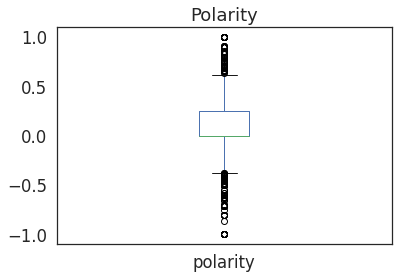

In [23]:
sns.set(font_scale=1.5, style='white')
df.polarity.plot(kind='box',title='Polarity')
plt.show()

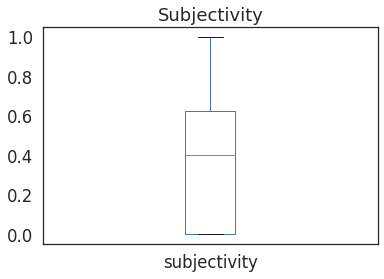

In [24]:
sns.set(font_scale=1.5, style='white')
df.subjectivity.plot(kind='box',title='Subjectivity')
plt.show()

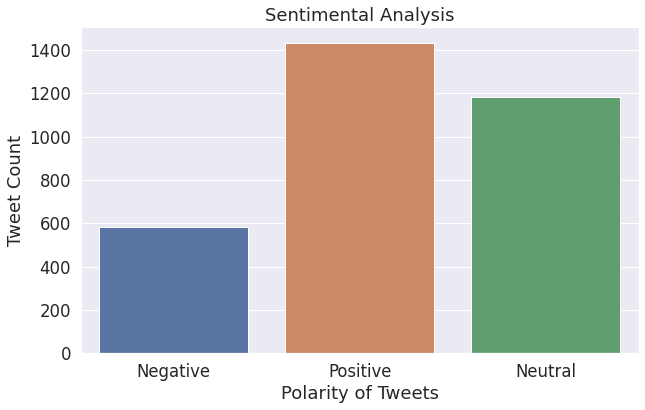

In [27]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.countplot(x='Analysis', data=df)
plt.title('Sentimental Analysis')
plt.xlabel('Polarity of Tweets')
plt.ylabel('Tweet Count')
plt.show()

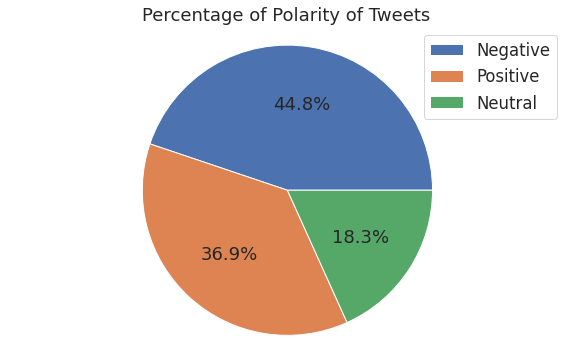

In [36]:
sns.set(font_scale=1.5, style='white')
labels = df.Analysis.unique()
plt.figure(figsize=(10,6))
plt.pie(df['Analysis'].value_counts(), autopct='%.1f%%', explode=[0,0,0], labeldistance=1.01)
plt.axis('equal')
plt.legend(labels, loc=1)
plt.title('Percentage of Polarity of Tweets')
plt.show()

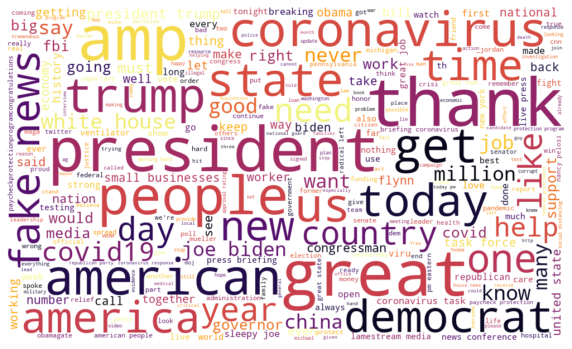

In [33]:
allWords = ' '.join([twts for twts in text['Tweets']])

wordCloud = WordCloud(width=1000, 
                      height=600, 
                      max_words= 300, 
                      random_state=7, 
                      max_font_size=119, 
                      background_color='white',
                      colormap='inferno',
                      stopwords= set(stopwords.words('english'))).generate(allWords)

plt.figure(figsize=(10,8))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

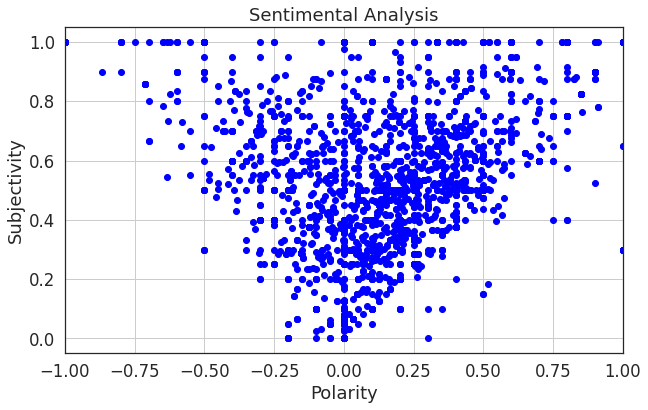

In [34]:
sns.set(font_scale=1.5, style='white')
plt.figure(figsize=(10,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i], color='blue')

plt.title('Sentimental Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.xlim(-1,1)
plt.grid()
plt.show()